# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [1]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Pablo environnement

In [2]:
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]
for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

In [3]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U234', 6.11864E-06, 'ao')
uo2.add_nuclide('U235', 7.18132E-04, 'ao')
uo2.add_nuclide('U236', 3.29861E-06, 'ao')
uo2.add_nuclide('U238', 2.21546E-02, 'ao')
uo2.add_nuclide('O16', 4.57642E-02, 'ao')
uo2.set_density('g/cm3', 10.257 )
uo2.temperature=565

zirconium = openmc.Material(name="zirconium")
zirconium.add_nuclide('Zr90', 2.18865E-02, 'ao')
zirconium.add_nuclide('Zr91', 4.77292E-03, 'ao')
zirconium.add_nuclide('Zr92', 7.29551E-03, 'ao')
zirconium.add_nuclide('Zr94', 7.39335E-03, 'ao')
zirconium.add_nuclide('Zr96', 1.19110E-03, 'ao')
zirconium.add_nuclide('Sn112',4.68066E-06, 'ao')
zirconium.add_nuclide('Sn114', 3.18478E-06, 'ao')
zirconium.add_nuclide('Sn115', 1.64064E-06, 'ao')
zirconium.add_nuclide('Sn116', 7.01616E-05, 'ao')
zirconium.add_nuclide('Sn117', 3.70592E-05, 'ao')
zirconium.add_nuclide('Sn118', 1.16872E-04, 'ao')
zirconium.add_nuclide('Sn119', 4.14504E-05, 'ao')
zirconium.add_nuclide('Sn120', 1.57212E-04, 'ao')
zirconium.add_nuclide('Sn122', 2.23417E-05, 'ao')
zirconium.add_nuclide('Sn124', 2.79392E-05, 'ao')
zirconium.add_nuclide('Fe54', 8.68307E-06, 'ao')
zirconium.add_nuclide('Fe56', 1.36306E-04, 'ao')
zirconium.add_nuclide('Fe57', 3.14789E-06, 'ao')
zirconium.add_nuclide('Fe58', 4.18926E-07, 'ao')
zirconium.add_nuclide('Cr50', 3.30121E-06, 'ao')
zirconium.add_nuclide('Cr52', 6.36606E-05, 'ao')
zirconium.add_nuclide('Cr53', 7.21860E-06, 'ao')
zirconium.add_nuclide('Cr54', 1.79686E-06, 'ao')
zirconium.add_nuclide('Hf174', 3.54138E-09, 'ao')
zirconium.add_nuclide('Hf176', 1.16423E-07, 'ao')
zirconium.add_nuclide('Hf177', 4.11686E-07, 'ao')
zirconium.add_nuclide('Hf178', 6.03806E-07, 'ao')
zirconium.add_nuclide('Hf179', 3.01460E-07, 'ao')
zirconium.add_nuclide('Hf180', 7.76449E-07, 'ao')
zirconium.set_density('g/cm3',  6.56)

water = openmc.Material(name="water")
water.add_nuclide('H1',4.96224E-02, 'ao')
water.add_nuclide('O16', 2.48112E-02, 'ao')
water.add_nuclide('B10', 1.07070E-05, 'ao')
water.add_nuclide('B11', 4.30971E-05, 'ao')
water.temperature=565
water.set_density('g/cm3', 0.743)
water.add_s_alpha_beta('c_H_in_H2O')

helium = openmc.Material(name="helium")
helium.add_nuclide('He4',1, 'ao')
helium.temperature=565
helium.set_density('g/cm3', 0.178E-03 )


model.materials = openmc.Materials([uo2, zirconium, water,helium]) 
#Perso path
model.materials.cross_sections = '/home/pablo/internship/xs_for_input/cross_sections.xml'
#Mac path
# model.materials.cross_sections = '/Users/pablogarcia44/repo/endfb-vii.1-hdf5/cross_sections.xml'

### Create pincell

In [4]:
def pincell(family):
    fuel_outer_radius = openmc.ZCylinder(r=0.4096)
    clad_inner_radius = openmc.ZCylinder(r=0.418)
    clad_outer_radius = openmc.ZCylinder(r=0.475)
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    fuel_region = -fuel_outer_radius
    gap_region = +fuel_outer_radius & -clad_inner_radius
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    fuel = openmc.Cell(name='fuel'+'_'+family)
    fuel.fill = uo2
    fuel.region = fuel_region
    gap = openmc.Cell(name='gap'+'_'+family)
    gap.region = gap_region
    gap.fill = helium     
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u'+'_'+family,cells=(fuel, clad, moderator,gap))
    return(u,fuel,clad,moderator,gap)

In [5]:
def pincell_side(family):
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    water_region = +left & -right & +bottom & -top 
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u'+'_'+family)
    u.add_cell(moderator)
    return(u,moderator)

### Create guide tube

In [6]:
def guide(family):
    clad_inner_radius = openmc.ZCylinder(r=0.561)
    clad_outer_radius = openmc.ZCylinder(r=0.602)
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')       
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    water_guide_region= -clad_inner_radius
    water_guide = openmc.Cell(name='water'+'_'+family)
    water_guide.fill = water
    water_guide.region = water_guide_region
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u_guide'+'_'+family,cells=(water_guide, clad, moderator))
    return(u,water_guide,water_guide,clad,moderator)

### Create instrumentation tube

In [7]:
def instru(family):
    clad_inner_radius = openmc.ZCylinder(r=0.559)
    clad_outer_radius = openmc.ZCylinder(r=0.605)
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')       
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    water_guide_region= -clad_inner_radius
    water_guide = openmc.Cell(name='water'+'_'+family)
    water_guide.fill = water
    water_guide.region = water_guide_region
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u_guide'+'_'+family,cells=(water_guide, clad, moderator))
    return(u,water_guide,water_guide,clad,moderator)

### Mappping

In [8]:
GT=[(5,2),(8,2),(3,3),(2,5),(5,5),(8,5),(2,8),(5,8)]
IT=[(8,8)]

GT_left=[]
GT_full=[]
for X in GT:
    GT_left.append((X[0],X[1]))
    GT_left.append((X[0],16-X[1]))
for X in GT_left:
    GT_full.append((X[0],X[1]))
    GT_full.append((16-X[0],X[1]))    
GT_full = list(set(GT_full))
print(GT_full)

[(3, 13), (11, 2), (11, 5), (11, 8), (2, 5), (11, 14), (2, 11), (11, 11), (2, 8), (3, 3), (8, 2), (8, 5), (8, 11), (8, 14), (13, 13), (14, 5), (14, 11), (5, 2), (14, 8), (5, 5), (5, 11), (5, 8), (5, 14), (13, 3)]


### Create family pincell

### Define assembly

In [9]:
pitch=1.26
dr=0.04
size=19
def create_assembly(family):
    pincell_fam=pincell(family+'_'+'pincell')
    guide_fam=guide(family+'_'+'guide')
    instru_fam=instru(family+'_'+'instru')
    side_fam=pincell_side(family+'_'+'outside')
    
    
    assembly = openmc.RectLattice()
    assembly.pitch = (pitch,pitch)
    assembly.lower_left = (-size/2*pitch, -size/2*pitch)
    


    A= np.empty((size, size), dtype=openmc.universe.Universe)

    for ix in range(size):
        for iy in range(size):
            if (ix-1,iy-1) in GT_full : 
                A[ix][iy]=guide_fam[0]
            elif ix==0 or ix==18 or iy==0 or iy==18:
                A[ix][iy]=side_fam[0]
            elif (ix-1,iy-1) in IT :
                A[ix][iy]=instru_fam[0]
            else:
                A[ix][iy]=pincell_fam[0]    
        
    assembly.universes = A

    
    rod_height=385.1
    
    
    assembly_cell= openmc.Cell(name='assembly_cell', fill=assembly)

    assembly_universe = openmc.Universe(name='assembly_universe')
    assembly_universe.add_cell(assembly_cell)
    print(assembly_universe)
    min_x = openmc.XPlane(x0=-((size-2)*pitch/2+dr), boundary_type='reflective')
    max_x = openmc.XPlane(x0=+((size-2)*pitch/2+dr), boundary_type='reflective')
    min_y = openmc.YPlane(y0=-((size-2)*pitch/2+dr), boundary_type='reflective')
    max_y = openmc.YPlane(y0=+((size-2)*pitch/2+dr), boundary_type='reflective')
    min_z = openmc.ZPlane(z0=-rod_height/2, boundary_type='reflective')
    max_z = openmc.ZPlane(z0=+rod_height/2, boundary_type='reflective')
    root_cell = openmc.Cell(name='root cell', fill=assembly_universe)
    root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cell(root_cell)
    return(root_universe,pincell_fam,guide_fam,instru_fam,assembly_cell)
    
    

Universe
	ID             =	6
	Name           =	assembly_universe
	Geom           =	CSG
	Cells          =	[12]



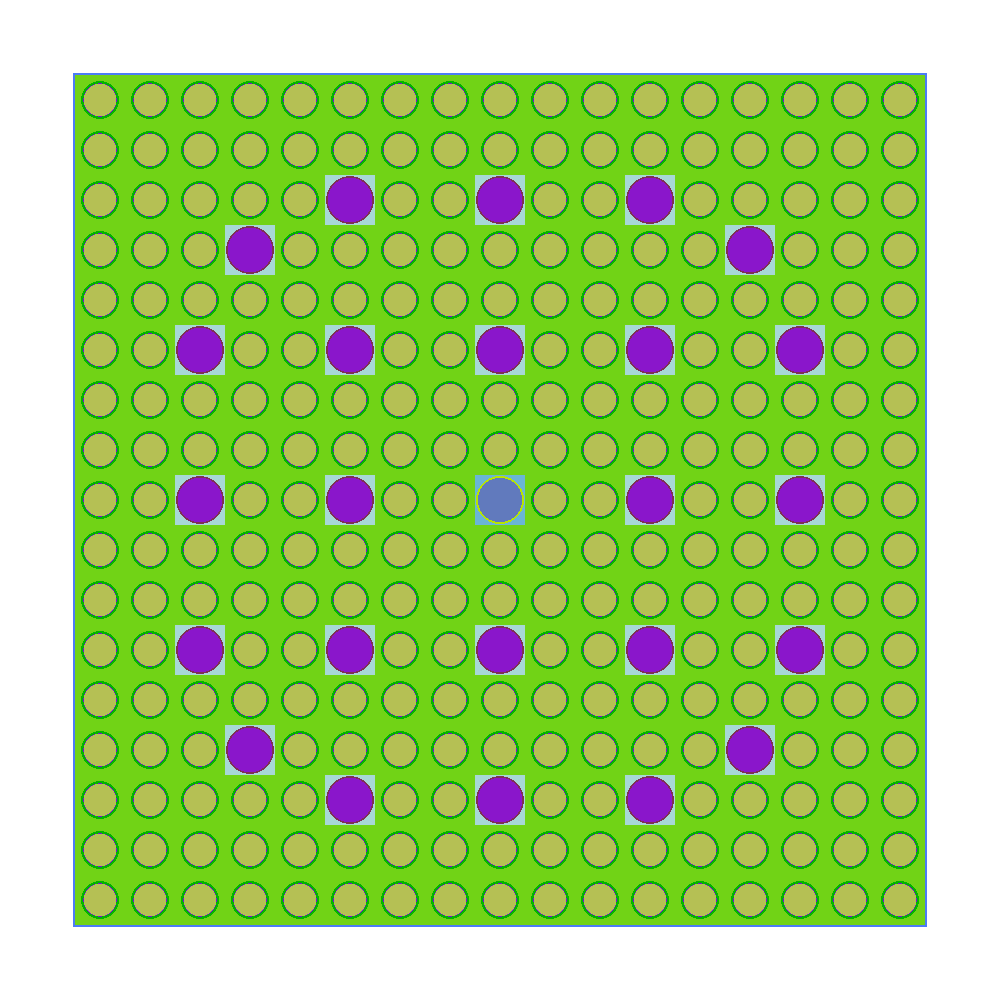

In [10]:
# dr=0.04
# min_x = openmc.XPlane(x0=-((size-2)*pitch/2+dr), boundary_type='reflective')
# max_x = openmc.XPlane(x0=+((size-2)*pitch/2+dr), boundary_type='reflective')
# min_y = openmc.YPlane(y0=-((size-2)*pitch/2+dr), boundary_type='reflective')
# max_y = openmc.YPlane(y0=+((size-2)*pitch/2+dr), boundary_type='reflective')
# min_z = openmc.ZPlane(z0=-rod_height/2, boundary_type='reflective')
# max_z = openmc.ZPlane(z0=+rod_height/2, boundary_type='reflective')

# root_cell = openmc.Cell(name='root cell', fill=create_assembly('C')[0])
# root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
# root_universe = openmc.Universe(name='root universe')
# root_universe.add_cell(root_cell)

model.geometry.root_universe = create_assembly('C')[0]
model.materials.export_to_xml()
model.geometry.export_to_xml()
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (1000, 1000)
plot.width = (pitch*20, pitch*20)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
plot.to_ipython_image()

In [11]:
assembly_1fam=create_assembly('1fam')



Universe
	ID             =	13
	Name           =	assembly_universe
	Geom           =	CSG
	Cells          =	[25]



In [12]:
C_full=[(0,0),(2,2),(2,0),(0,2)]
E_full=[(1,0),(0,1),(1,2),(2,1)]
M_full=[(1,1)]

In [13]:
pitch=1.26

dr=0.04 # cm of water that is outside assembly


size=17 #size of the assembly 
pitch_assembly=size*pitch+2*dr 
core = openmc.RectLattice()

size_core=3
core.pitch = (pitch_assembly,pitch_assembly)

core.lower_left = (-size_core/2*pitch_assembly, -size_core/2*pitch_assembly)


A= np.empty((size_core, size_core), dtype=openmc.universe.Universe)

for ix in range(size_core):
    for iy in range(size_core):
        if (ix,iy) in C_full : 
            A[ix][iy]=assembly_1fam[0]
        elif (ix,iy) in E_full :
            A[ix][iy]=assembly_1fam[0]
        elif (ix,iy) in M_full :
            A[ix][iy]=assembly_1fam[0] 

      
core.universes = A




rod_height=385.1
# 1/4 assembly
min_x = openmc.XPlane(x0=-(size_core/2*pitch_assembly), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(size_core/2*pitch_assembly), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-rod_height/2, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+rod_height/2, boundary_type='reflective')


root_cell = openmc.Cell(name='root cell', fill=core)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z



model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)

### Plot

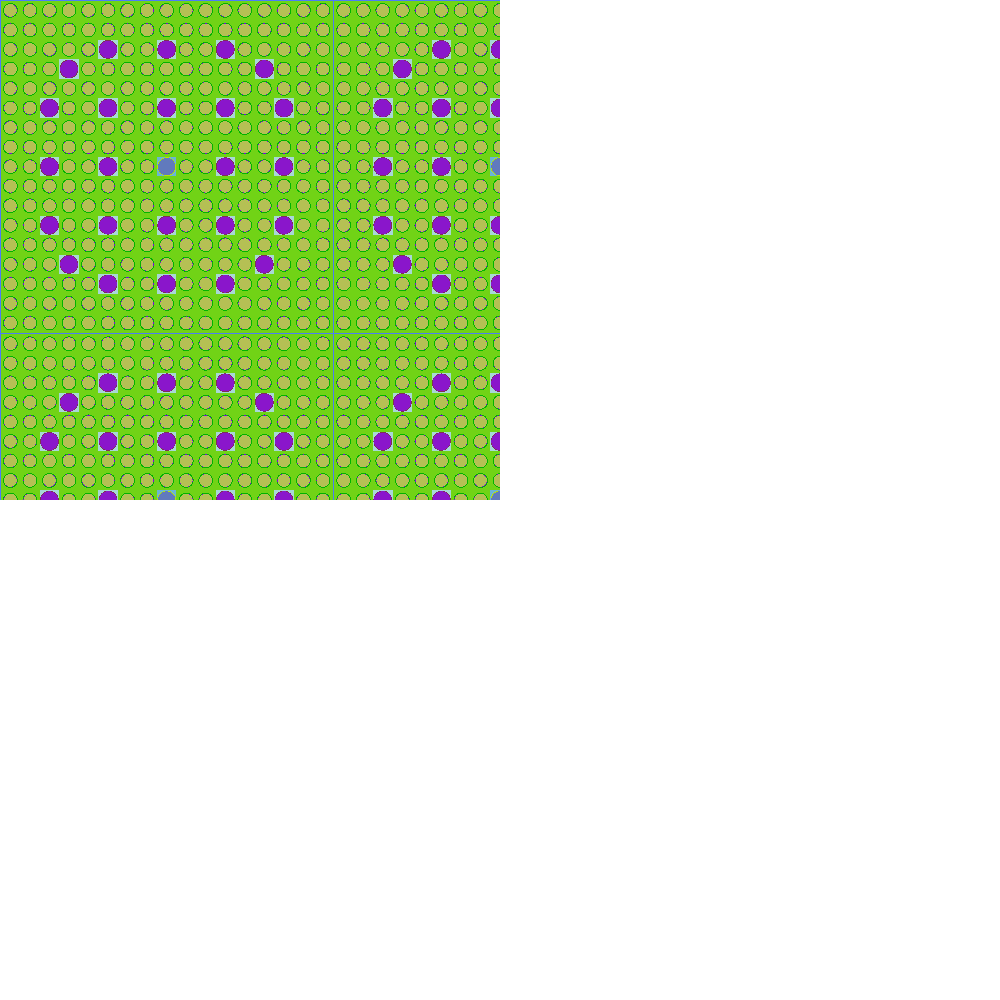

In [14]:
model.materials.export_to_xml()
model.geometry.export_to_xml()
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (1000, 1000)
plot.width = (pitch_assembly*3, pitch_assembly*3)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
plot.to_ipython_image()
# print(model.geometry.get_all_material_cells().values())

### Choose settings

In [15]:
bounds = [-pitch_assembly/2, 0, -10, 0, +pitch_assembly/2, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 20
settings.particles = 50000
settings.keff_trigger = {'type':'std_dev','threshold':0.00010}
settings.trigger_active = True
settings.trigger_max_batches = 50000
settings.output = {'tallies':True}
settings.temperature['method'] = 'interpolation'
model.settings = settings

### Define and choose energy group

In [16]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['SHEM-361']
name_group='SHEM-361'


### Create MGXS tallies for mgxs directory

In [17]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission' ,'chi', 'consistent nu-scatter matrix', 'multiplicity matrix','kappa-fission']
#mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
model.tallies = tallies

#model.export_to_xml()
# model.export_to_model_xml('model_1_gap.xml')

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [ ]:
sp_file = model.run()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=400.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=10.
  warn(msg, IDWarning)


[Machine2:12863] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%